Creating animation... This may take a moment.


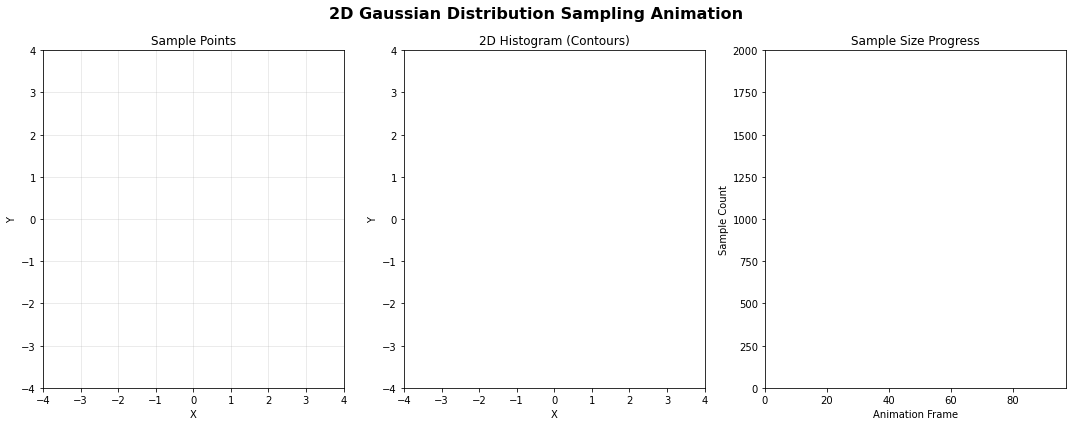

Animation complete! Showing 2000 samples from 2D Gaussian distribution.
Mean: [0, 0]
Covariance matrix:
[[1.  0.5]
 [0.5 1. ]]


"\ndef animate_method2(frame):\n    # This is an alternative approach that manually removes contour collections\n    # instead of clearing the entire axes. More efficient but more complex.\n    \n    global contour_objects\n    \n    # Remove previous contour collections if they exist\n    if 'contour_objects' in globals():\n        for obj in contour_objects:\n            for collection in obj.collections:\n                collection.remove()\n    \n    # Create new contours and store references\n    # ... (histogram creation code same as above)\n    \n    contour_filled = ax2.contourf(X, Y, hist.T, levels=levels, cmap='viridis')\n    contour_lines = ax2.contour(X, Y, hist.T, levels=levels, colors='white')\n    \n    # Store references for next frame\n    contour_objects = [contour_filled, contour_lines]\n    \n    return []\n"

<Figure size 432x288 with 0 Axes>

In [4]:
"""
METHODS FOR UPDATING CONTOURS IN MATPLOTLIB ANIMATIONS:

Method 1: Clear and Redraw (Used here - Recommended for contours)
- Use ax.clear() to remove all previous contour objects
- Redraw everything from scratch each frame
- Simple and reliable, works well for contours
- Slight performance cost but ensures clean updates

Method 2: Remove Collections (Alternative approach)
- Store contour objects and remove them manually:
  for collection in contour_filled.collections:
      collection.remove()
  for collection in contour_lines.collections:
      collection.remove()
- More efficient but requires careful management

Method 3: Update Data (Not suitable for contours)
- Works for line plots: line.set_data(x, y)
- NOT recommended for contours as they create complex collection objects
- Contours don't have simple set_data methods

Method 4: Artist Animation (Advanced)
- Pre-compute all frames and store as artists
- Most efficient for complex animations
- Requires more memory and setup complexity

For contour animations, Method 1 (clear/redraw) is usually the best choice!
"""

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap

# Set up the figure and subplots
fig = plt.figure(figsize=(15, 6))
fig.suptitle('2D Gaussian Distribution Sampling Animation', fontsize=16, fontweight='bold')

# Create subplots
ax1 = plt.subplot(1, 3, 1)  # Scatter plot of samples
ax2 = plt.subplot(1, 3, 2)  # 2D histogram with contours
ax3 = plt.subplot(1, 3, 3)  # Sample count progress

# Parameters for the 2D Gaussian
mean = [0, 0]
cov = [[1, 0.5], [0.5, 1]]  # Covariance matrix with some correlation

# Animation parameters
max_samples = 2000
sample_increments = np.logspace(1, np.log10(max_samples), 100).astype(int)
sample_increments = np.unique(sample_increments)  # Remove duplicates

# Generate all samples at once for consistency
np.random.seed(42)  # For reproducible results
all_samples = np.random.multivariate_normal(mean, cov, max_samples)

# Set up the plots
ax1.set_xlim(-4, 4)
ax1.set_ylim(-4, 4)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Sample Points')
ax1.grid(True, alpha=0.3)

ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('2D Histogram (Contours)')

ax3.set_xlim(0, len(sample_increments))
ax3.set_ylim(0, max_samples)
ax3.set_xlabel('Animation Frame')
ax3.set_ylabel('Sample Count')
ax3.set_title('Sample Size Progress')

# Create custom colormap for contours
colors = ['#440154', '#31688e', '#35b779', '#fde725']  # Viridis-like colors
n_bins = 256
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

def animate(frame):
    # Get current sample count
    n_samples = sample_increments[frame]
    current_samples = all_samples[:n_samples]
    
    # Method 1: Clear and redraw (simple but effective for contours)
    # This is the most straightforward approach for contour animations
    
    # Update scatter plot
    ax1.clear()
    ax1.set_xlim(-4, 4)
    ax1.set_ylim(-4, 4)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title('Sample Points')
    ax1.grid(True, alpha=0.3)
    
    # Plot samples with alpha based on density
    alpha = min(1.0, 500 / n_samples)
    ax1.scatter(current_samples[:, 0], current_samples[:, 1], 
               s=1, alpha=alpha, c='red', edgecolors='none')
    
    # Add sample count text
    ax1.text(0.02, 0.98, f'Samples: {n_samples}', transform=ax1.transAxes, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
            verticalalignment='top', fontsize=10)
    
    # Update histogram contours
    ax2.clear()
    ax2.set_xlim(-4, 4)
    ax2.set_ylim(-4, 4)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('2D Histogram (Contours)')
    ax2.grid(True, alpha=0.3)
    
    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(current_samples[:, 0], current_samples[:, 1], 
                                         bins=30, range=[[-4, 4], [-4, 4]])
    
    # Only plot if we have enough samples to create meaningful contours
    if n_samples > 10 and hist.max() > 0:
        # Create meshgrid for contour plot
        X, Y = np.meshgrid((xedges[:-1] + xedges[1:]) / 2, (yedges[:-1] + yedges[1:]) / 2)
        
        # Create adaptive contour levels
        max_val = hist.max()
        if max_val > 0:
            # Use logarithmic spacing for better visualization
            levels = np.geomspace(max_val * 0.1, max_val, 8)
            
            # Plot filled contours
            contour_filled = ax2.contourf(X, Y, hist.T, levels=levels, 
                                        cmap='viridis', alpha=0.7, extend='max')
            
            # Plot contour lines for definition
            contour_lines = ax2.contour(X, Y, hist.T, levels=levels, 
                                      colors='white', alpha=0.9, linewidths=1.2)
            
            # Add contour labels for the highest levels
            if n_samples > 100:
                ax2.clabel(contour_lines, levels[-3:], inline=True, fontsize=8, fmt='%d')
    else:
        # For very few samples, just show scatter points
        ax2.scatter(current_samples[:, 0], current_samples[:, 1], 
                   s=20, alpha=0.6, c='red', edgecolors='black', linewidths=0.5)
        ax2.text(0.5, 0.5, f'Too few samples\nfor contours\n({n_samples} samples)', 
                transform=ax2.transAxes, ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Update progress plot
    frames_so_far = list(range(frame + 1))
    samples_so_far = sample_increments[:frame + 1]
    
    ax3.clear()
    ax3.set_xlim(0, len(sample_increments))
    ax3.set_ylim(0, max_samples)
    ax3.set_xlabel('Animation Frame')
    ax3.set_ylabel('Sample Count')
    ax3.set_title('Sample Size Progress')
    ax3.grid(True, alpha=0.3)
    
    ax3.plot(frames_so_far, samples_so_far, 'b-', linewidth=2)
    ax3.plot(frame, n_samples, 'ro', markersize=8)
    
    # Add theoretical contours on the first subplot for reference
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    
    # Calculate multivariate normal PDF
    def multivariate_gaussian(pos, mu, sigma):
        n = mu.shape[0]
        sigma_det = np.linalg.det(sigma)
        sigma_inv = np.linalg.inv(sigma)
        N = np.sqrt((2*np.pi)**n * sigma_det)
        fac = np.einsum('...k,kl,...l->...', pos-mu, sigma_inv, pos-mu)
        return np.exp(-fac / 2) / N
    
    pdf = multivariate_gaussian(pos, np.array(mean), np.array(cov))
    ax1.contour(X, Y, pdf, levels=3, colors='blue', alpha=0.5, linewidths=1.5)
    
    plt.tight_layout()
    return []

# Create animation
print("Creating animation... This may take a moment.")
anim = animation.FuncAnimation(fig, animate, frames=len(sample_increments), 
                              interval=100, blit=False, repeat=True)

# Display the plot
plt.tight_layout()
plt.show()

# Optional: Save animation as gif (uncomment the line below)
anim.save('2d_gaussian_sampling.gif', writer='pillow', fps=10)

print(f"Animation complete! Showing {max_samples} samples from 2D Gaussian distribution.")
print(f"Mean: {mean}")
print(f"Covariance matrix:\n{np.array(cov)}")

# Alternative Method 2: Manual Collection Removal (for reference)
"""
def animate_method2(frame):
    # This is an alternative approach that manually removes contour collections
    # instead of clearing the entire axes. More efficient but more complex.
    
    global contour_objects
    
    # Remove previous contour collections if they exist
    if 'contour_objects' in globals():
        for obj in contour_objects:
            for collection in obj.collections:
                collection.remove()
    
    # Create new contours and store references
    # ... (histogram creation code same as above)
    
    contour_filled = ax2.contourf(X, Y, hist.T, levels=levels, cmap='viridis')
    contour_lines = ax2.contour(X, Y, hist.T, levels=levels, colors='white')
    
    # Store references for next frame
    contour_objects = [contour_filled, contour_lines]
    
    return []
"""